# LIBRARIES

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import statsmodels.api as sm
import statistics as sts
import os
import numpy as np

os.chdir('/content/drive/MyDrive/macro 1 2023.2/lista 2 - macro 1 - dados macroeconômicos/lista 2 - macro 1 - dados macroeconômicos')

# Tratamento dos dados coletados no IPEADATA

In [27]:
# pib

pib = pd.read_csv('pib.csv',sep = ';', decimal=',')
pib = pib.rename(columns = {'PIB - preços de mercado - índice real encadeado dessazonalizado (média 1995 = 100) - - - Instituto Brasileiro de Geografia e Estatística, Sistema de Contas Nacionais Trimestrais (IBGE/SCN Trimestral) - SCN104_PIBPMAS104':'pib'})
pib = pib[['Data','pib']]

# consumo final

consumo_final = pd.read_csv('consumofinal_familias.csv', sep = ';', decimal = ',')
consumo_final = consumo_final.rename(columns = {'PIB - consumo final - famílias - índice real encadeado dessazonalizado (média 1995 = 100) - - - Instituto Brasileiro de Geografia e Estatística, Sistema de Contas Nacionais Trimestrais (IBGE/SCN Trimestral) - SCN104_PIBCPPAS104':'consumo_final'})
consumo_final = consumo_final[['Data','consumo_final']]

# gastos do governo

gastos = pd.read_csv('gastos_governo.csv', sep = ';', decimal = ',')
gastos = gastos.rename(columns = {'PIB - consumo final - APU - índice real encadeado dessazonalizado (média 1995 = 100) - - - Instituto Brasileiro de Geografia e Estatística, Sistema de Contas Nacionais Trimestrais (IBGE/SCN Trimestral) - SCN104_PIBCGGAS104': 'gastos do governo'})
gastos = gastos[['Data','gastos do governo']]

# investimento

invest = pd.read_csv('investimento.csv', sep = ';', decimal = ',')
invest = invest.rename(columns = {'PIB - formação bruta de capital fixo - índice real encadeado dessazonalizado (média 1995 = 100) - - - Instituto Brasileiro de Geografia e Estatística, Sistema de Contas Nacionais Trimestrais (IBGE/SCN Trimestral) - SCN104_PIBFBKFAS104': 'formacao bruta de capital fixo'})
invest = invest[['Data', 'formacao bruta de capital fixo']]

# indicadores industriais (dados mensais, tornar trimestrais)

industriais = pd.read_csv('indicadores_industriais.csv', sep =';', decimal = ',')
industriais = industriais.rename(columns = {'Indicadores Industriais - horas trabalhadas - indústria - índice dessazonalizado (média 2006 = 100) - - - Confederação Nacional da Indústria - CNI12_HTRABD12':'indicadores industriais'})
industriais = industriais[['Data', 'indicadores industriais']]

In [28]:
# sera necessario filtrar os dados da variavel indicadores industriais de 1996 T1:2023 T2

industriais['Data'] = pd.to_datetime(industriais['Data'])
industriais_filtrado = (industriais['Data'] >= '1996-01-01') & (industriais['Data'] <= '2023-06-01')
industriais = industriais[industriais_filtrado]

rate_list = industriais['indicadores industriais'].tolist()

# laço for para tornar os dados mensais em trimestrais

mes = len(industriais['Data'])
trimestrado = []
for i in range(0,mes,3):
    media_tri = round(sts.mean(rate_list[i:i+3]),2)
    trimestrado.append(media_tri)

data = pib['Data'].tolist()

industriais_tri = pd.DataFrame({'Data': data,
                                'taxa': trimestrado})

In [29]:
# unir as variaveis em um dataframe

tabela_variaveis = pd.DataFrame({'data': pib['Data'],
                                 'pib': pib['pib'],
                                 'consumo das familias': consumo_final['consumo_final'],
                                 'gastos do governo': gastos['gastos do governo'],
                                 'investimento': invest['formacao bruta de capital fixo'],
                                 'indicadores industriais': industriais_tri['taxa']})
tabela_variaveis = tabela_variaveis.set_index('data')

# Logaritmo Natural e filtro HP para obtencao da serie de tendência

In [30]:
tabela_variaveis_log = np.log(tabela_variaveis)

In [31]:
# pib

ciclo_pib, tendencia_pib = sm.tsa.filters.hpfilter(tabela_variaveis_log["pib"], 1600)

tabela_variaveis_log['ciclo_pib'] = ciclo_pib
tabela_variaveis_log['tendencia_pib'] = tendencia_pib

# consumo final

ciclo_consumo, tendencia_consumo = sm.tsa.filters.hpfilter(tabela_variaveis_log["consumo das familias"], 1600)

tabela_variaveis_log['ciclo_consumo'] = ciclo_consumo
tabela_variaveis_log['tendencia_consumo'] = tendencia_consumo

# gastos do governo

ciclo_gastos, tendencia_gastos = sm.tsa.filters.hpfilter(tabela_variaveis_log["gastos do governo"], 1600)

tabela_variaveis_log['ciclo_gastos'] = ciclo_gastos
tabela_variaveis_log['tendencia_gastos'] = tendencia_gastos

# investimento

ciclo_invest, tendencia_invest = sm.tsa.filters.hpfilter(tabela_variaveis_log["investimento"], 1600)

tabela_variaveis_log['ciclo_invest'] = ciclo_invest
tabela_variaveis_log['tendencia_invest'] = tendencia_invest

# indicadores industriais

ciclo_industriais, tendencia_industriais = sm.tsa.filters.hpfilter(tabela_variaveis_log["indicadores industriais"], 1600)

tabela_variaveis_log['ciclo_industriais'] = ciclo_industriais
tabela_variaveis_log['tendencia_industriais'] = tendencia_industriais

# Funções

In [32]:
def plot_tendencia(DataFrame,colunas, title, ano):
    plt.figure(figsize = (16,10))
    DataFrame[colunas].plot()
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.title('{} e serie de tendência ({})'.format(title, ano), fontsize=15)
    plt.show()

def plot_ciclo(DataFrame, coluna, title, ano):
    DataFrame[coluna].plot()
    plt.axhline(0,color='black')
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.title('{} - componente cíclico ({})'.format(title, ano), fontsize=15)
    plt.show()

def correlacao(x,y, title, ano):
    plt.scatter(x,y)
    plt.title('PIB x {} - correlacao ({})'.format(title, ano), fontsize=15)
    coef = np.polyfit(x, y, 1)
    polinomio = np.poly1d(coef)
    plt.plot(x, polinomio(x), color='red')
    plt.show()

# Gráficos

PIB: tendência e componente cíclico

<Figure size 1600x1000 with 0 Axes>

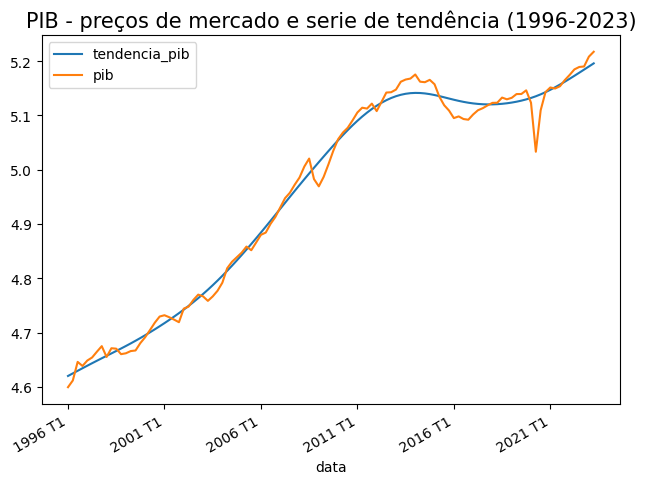

In [33]:
plot_tendencia(tabela_variaveis_log, ["tendencia_pib", "pib"], 'PIB - preços de mercado', '1996-2023')

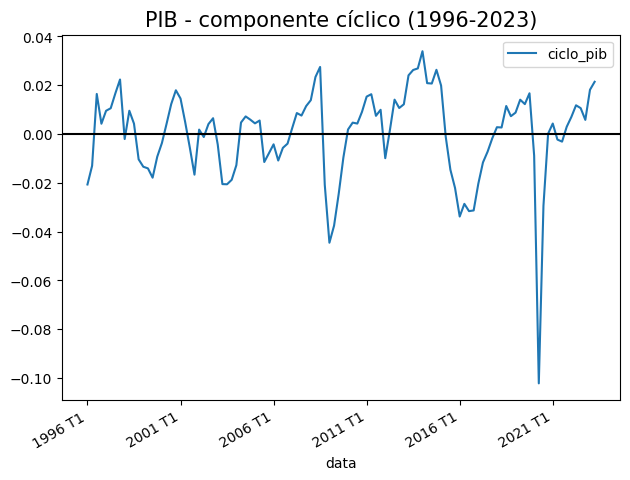

In [34]:
plot_ciclo(tabela_variaveis_log, ['ciclo_pib'], 'PIB', '1996-2023')

Consumo final das famílias: tendência e componente **cíclico**

<Figure size 1600x1000 with 0 Axes>

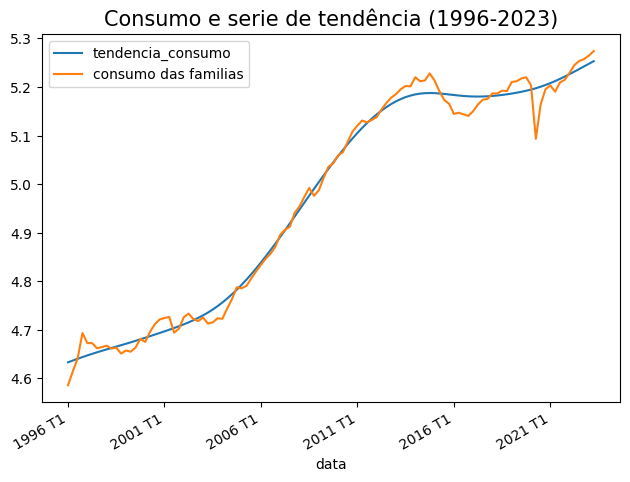

In [35]:
plot_tendencia(tabela_variaveis_log, ["tendencia_consumo", "consumo das familias"], 'Consumo', '1996-2023')

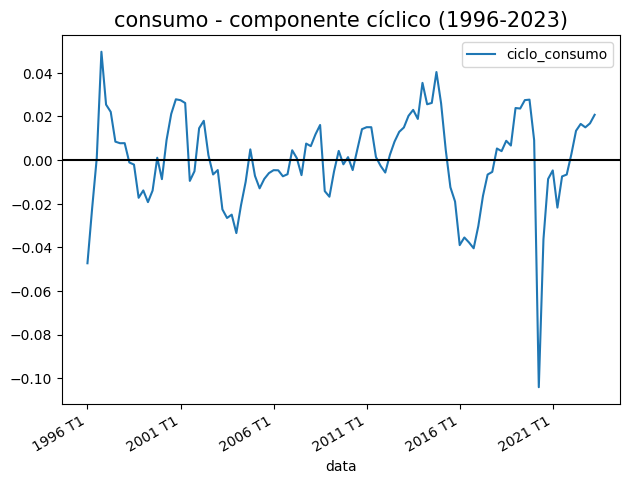

In [36]:
plot_ciclo(tabela_variaveis_log, ['ciclo_consumo'], 'consumo', '1996-2023')

Gastos do governo: tendência e componente cíclico

<Figure size 1600x1000 with 0 Axes>

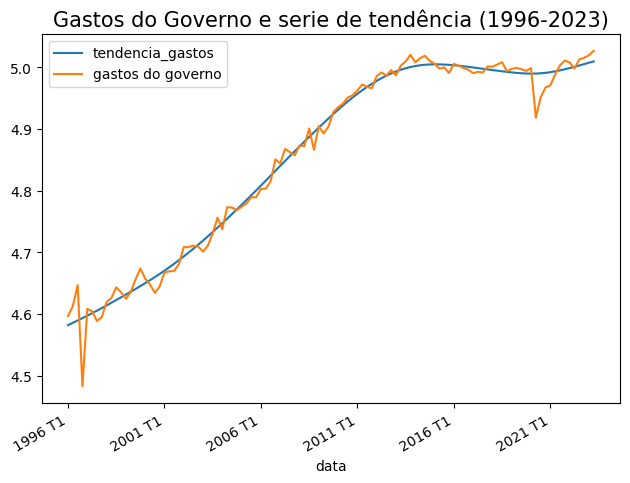

In [37]:
plot_tendencia(tabela_variaveis_log, ["tendencia_gastos", "gastos do governo"], 'Gastos do Governo', '1996-2023')

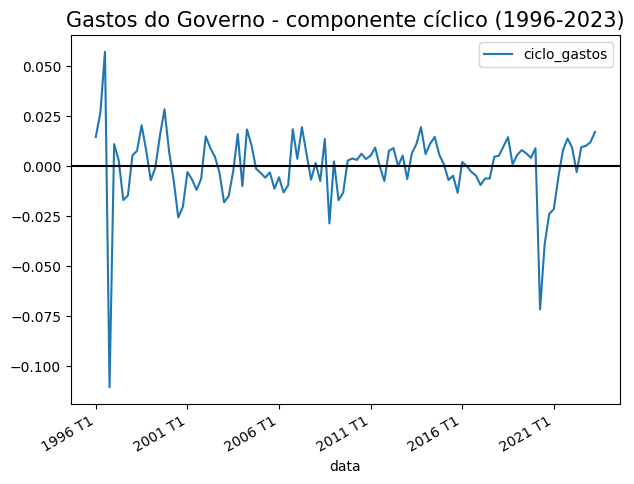

In [38]:
plot_ciclo(tabela_variaveis_log, ['ciclo_gastos'], 'Gastos do Governo', '1996-2023')

Investimento: tendência e componente cíclico

<Figure size 1600x1000 with 0 Axes>

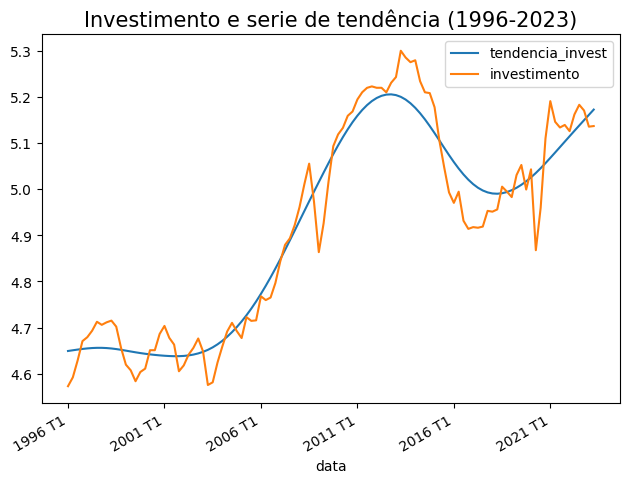

In [39]:
plot_tendencia(tabela_variaveis_log, ["tendencia_invest", "investimento"], 'Investimento', '1996-2023')

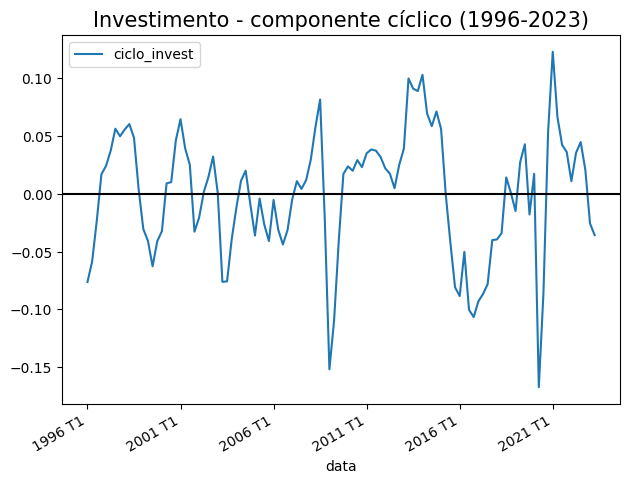

In [40]:
plot_ciclo(tabela_variaveis_log, ['ciclo_invest'], 'Investimento', '1996-2023')

Indicadores industriais: tendência e componente cíclico

<Figure size 1600x1000 with 0 Axes>

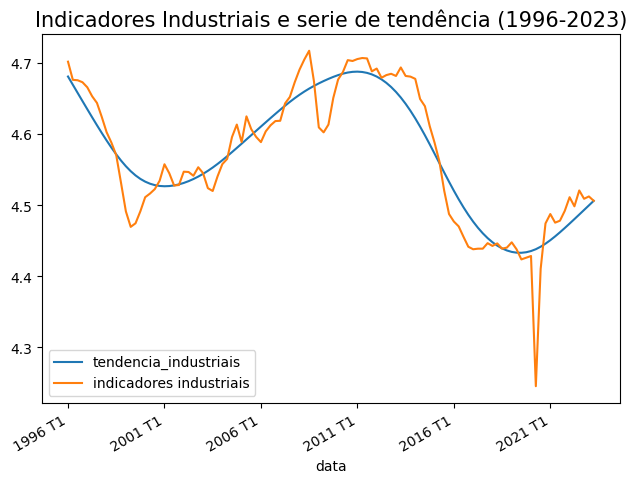

In [41]:
plot_tendencia(tabela_variaveis_log, ["tendencia_industriais", "indicadores industriais"], 'Indicadores Industriais', '1996-2023')

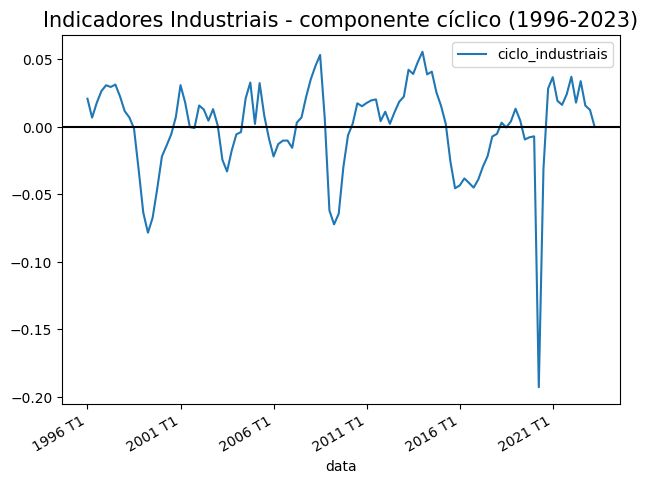

In [42]:
plot_ciclo(tabela_variaveis_log, ['ciclo_industriais'], 'Indicadores Industriais', '1996-2023')

# Gráficos de Dispersão: componentes cíclicos em relação ao componente cíclico do PIB

PIB x Consumo Final das Famílias

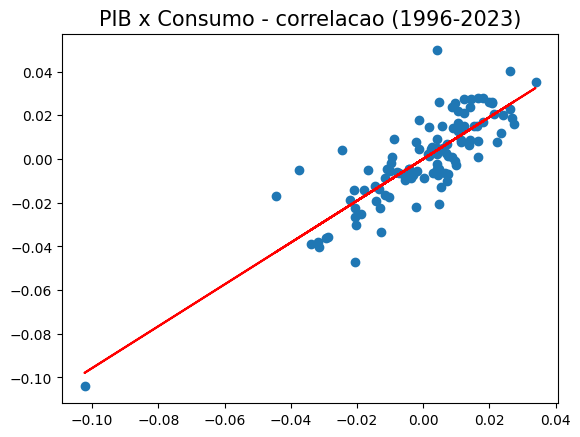

In [43]:
correlacao(ciclo_pib, ciclo_consumo,'Consumo', '1996-2023')

PIB x Gastos do Governo

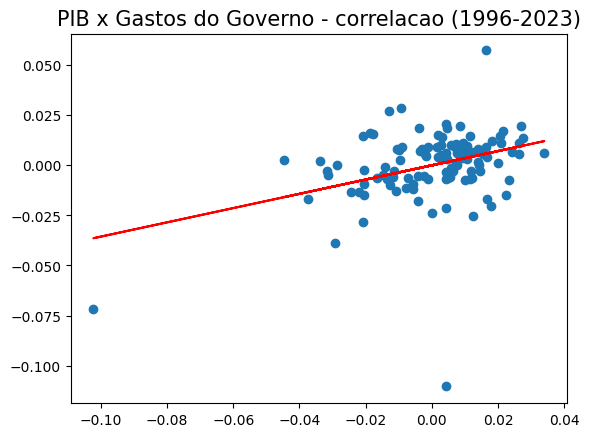

In [44]:
correlacao(ciclo_pib, ciclo_gastos,'Gastos do Governo', '1996-2023')

PIB x Investimento

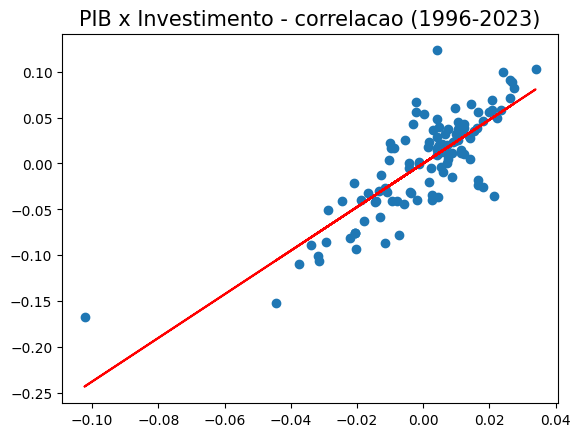

In [45]:
correlacao(ciclo_pib, ciclo_invest,'Investimento', '1996-2023')

PIB x Indicadores Industriais

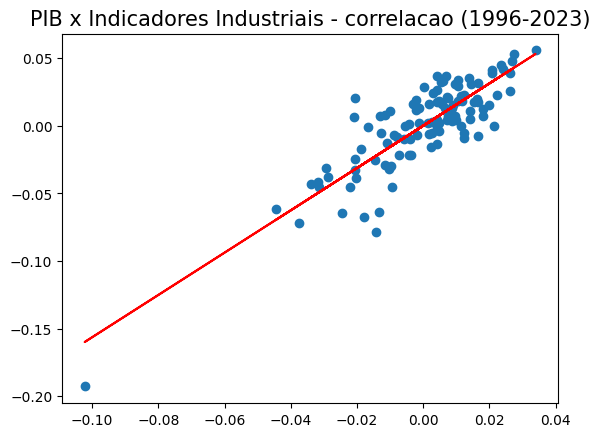

In [46]:
correlacao(ciclo_pib, ciclo_industriais,'Indicadores Industriais', '1996-2023')

# Construção de tabela de correlação e desvio padrão em relação ao PIB

In [72]:
# calculo de correlacao em relacao ao pib
# correlacao = pib.corr(x)

pib_consumo = ciclo_pib.corr(ciclo_consumo)
pib_gastos = ciclo_pib.corr(ciclo_gastos)
pib_invest = ciclo_pib.corr(ciclo_invest)
pib_indust = ciclo_pib.corr(ciclo_industriais)

correlacao = ['-', pib_consumo, pib_gastos, pib_invest, pib_indust]
# desvio padrao do componente ciclico
# desv_pad = x.std()

desv_pad_pib = ciclo_pib.std()
desv_pad_consumo = ciclo_consumo.std()
desv_pad_gastos = ciclo_gastos.std()
desv_pad_invest = ciclo_invest.std()
desv_pad_indust = ciclo_industriais.std()

desv_pad = [desv_pad_pib, desv_pad_consumo, desv_pad_gastos, desv_pad_invest, desv_pad_indust]

# desvio padrao da serie relativo ao pib

razao = ['-']
for i in range(1,5):
    razao.append(desv_pad[i]/desv_pad[0])

tabelinha = pd.DataFrame({'correlação': correlacao,
                          'desvio padrão': desv_pad,
                          'desvio padrão da série relativo ao PIB': razao},
                          index = ['PIB','Consumo', 'Gastos do Governo','Investimento (FBCF)','Indicadores Industriais'])

,correlação,desvio padrão,desvio padrão da série relativo ao PIB
PIB,-,0.018511,-
Consumo,0.840876,0.021075,1.138497
Gastos do Governo,0.363589,0.018119,0.978785
Investimento (FBCF),0.813462,0.054045,2.919528
Indicadores Industriais,0.852808,0.033959,1.834471
